# GEQIE LPIQE Example

## Setup

### Imports

In [127]:
import numpy as np
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
# import seaborn as sns

import geqie
from geqie.encodings import lpiqe

## Encoding

### Opening the image

Opening the test image and normalizing its pixel values to $[0.0, 1.0]$.

In [128]:
image = Image.open("../assets/rgb4x4.png")
image = ImageOps.grayscale(image)
image = np.asarray(image)
image

array([[ 76,  76, 150, 226],
       [ 76, 226, 226,  75],
       [105,  29, 255, 119],
       [ 15,  15,   0,   0]], dtype=uint8)

### Encoding using unitary gate

In [129]:
circuit = geqie.encode(lpiqe.init_function, lpiqe.data_function, lpiqe.map_function, image)
circuit.h(0)

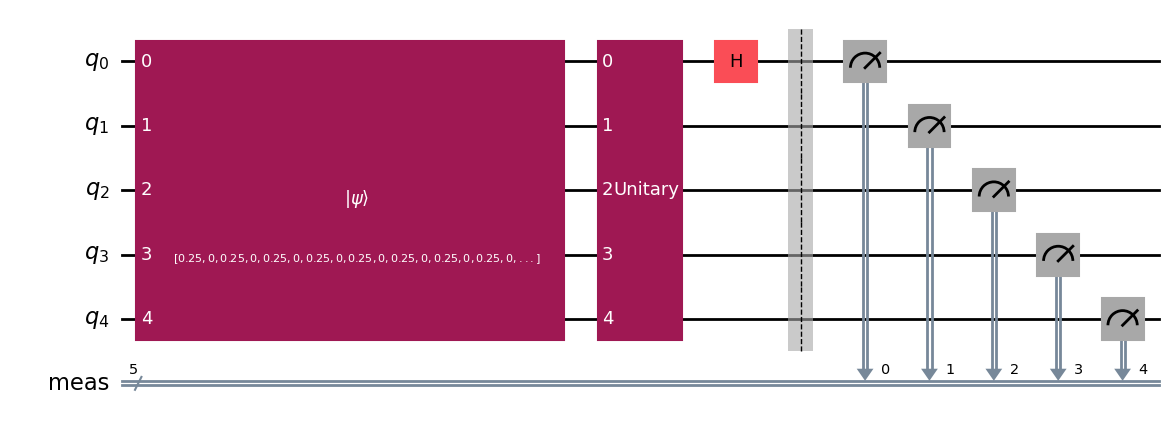

In [130]:
circuit.measure_all()
circuit.draw(output='mpl')

### Simulating the circuit

In [131]:

shoots = 8000
counts = geqie.simulate(circuit, shoots)
counts = {key: counts[key] for key in sorted(counts)}
counts

{'00000': 264,
 '00001': 261,
 '00010': 255,
 '00011': 257,
 '00100': 247,
 '00101': 247,
 '00110': 229,
 '00111': 231,
 '01000': 264,
 '01001': 248,
 '01010': 279,
 '01011': 241,
 '01100': 243,
 '01101': 269,
 '01110': 266,
 '01111': 261,
 '10000': 244,
 '10001': 228,
 '10010': 239,
 '10011': 230,
 '10100': 254,
 '10101': 246,
 '10110': 241,
 '10111': 282,
 '11000': 272,
 '11001': 223,
 '11010': 266,
 '11011': 266,
 '11100': 237,
 '11101': 226,
 '11110': 263,
 '11111': 221}

## Interpretation of the results

Image is represented as:
$$I_m=\begin{bmatrix}
p_{00} & p_{01} \\
p_{10} & p_{11} \\
\end{bmatrix}$$

and we encode it as:
$$L(I_m)=\begin{bmatrix}
e^{ip_0} & & & \\
& e^{ip_1} & & \\
& & e^{ip_2} & \\
& & & e^{ip_3}
\end{bmatrix}$$

<img src=".LPIQE_drawIO.png" width="800">

Number of qubits equalls to $q = log_2(W)+log_2(H)+1$.
Last qubit is always ancilla (blue color).

Procedure of gates combination:
1. Put Hadamard gates on all qubits.
2. Place Local Phase Operator and join it with identity gate: $\ket{Unitary\_operator}\bra{Unitary\_operator} \otimes I$.
3. Place Hadamard gate on last qubit.
4. Measure qubits.

Reconstructed pixel formula:
$$p_k=arccos\left(\frac{2^{length+1}* counts(p_k)}{2} - 1\right)$$



In [132]:
repr_range = (0.25*np.pi, 0.45*np.pi)#(.2*np.pi, 0.395*np.pi)
img = np.zeros_like(image).astype(float)

for result in sorted(counts.keys()):
    length = len(result)
    if result[length-1] == '0':
        
        p0 = counts[result] / shoots
        xx = result[0:2]       
        yy = result[2:4]
        
        u = int(yy, 2)
        v = int(xx, 2)


        x = (2 ** (length+1) / 2) * p0 - 1 # 2**length - normalization factor
        if x < -1:
            print(
                "The cos(p), p-experimentally determined probability for eigen state |" + result +
                '> which maps pixel [' +
                str(u) + ', ' + str(v) + '] is below -1.\n cos(p) changed to -1 to be able to compute arc cos!')
            x = -1

        if x > 1:
            print(
                "The cos(p), p-experimentally determined probability for eigen state |" + result +
                '> which maps pixel [' +
                str(u) + ', ' + str(v) + '] is over 1.\n cos(p) changed to 1 to be able to compute arc cos!')
            x = 1

        img[v, u] = np.arccos(x)
        rl = repr_range[1] - repr_range[0]  # the representation range length
        img[u, v] = img[u, v] / rl - repr_range[0] / rl  # inverse of mapping to representation range

reconstructedImage = np.flipud(img)
reconstructedImage


print('\nOriginal image:')
print(image)
print('Retrived image:')
print(f"{reconstructedImage}")



Original image:
[[ 76  76 150 226]
 [ 76 226 226  75]
 [105  29 255 119]
 [ 15  15   0   0]]
Retrived image:
[[1.48268235 1.50675256 1.62281979 1.16720209]
 [1.59479863 1.61481054 1.22453412 1.30730816]
 [1.51476702 1.0649637  1.29456921 1.14807117]
 [1.16082658 1.21816689 1.26909905 1.38384787]]


### Retrived image

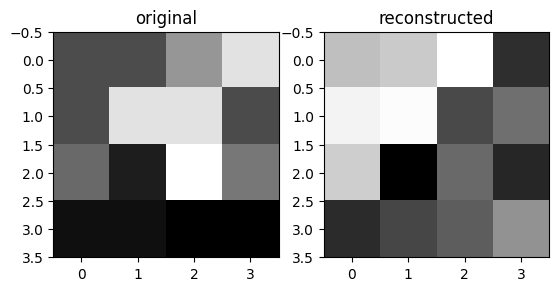

In [133]:
f = plt.figure()
gs = f.add_gridspec(1, 2)

ax = f.add_subplot(gs[0, 0])
ax.set_title("original")
ax.imshow(image, cmap='gray')

ax = f.add_subplot(gs[0, 1])
ax.set_title("reconstructed")
ax.imshow(reconstructedImage, cmap='gray')
